In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions (the 

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14850 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.04069949e-01  1.14337601e-01 -2.39954236e-01  1.49773023e-01
 -1.04335949e-01 -4.76659013e-02 -1.69266234e-01  1.10440096e-02
 -9.66701849e-02 -1.90833829e-01  1.21325044e-01 -1.88709551e-01
  4.18786724e-03 -2.19663133e-01 -7.98572937e-04 -1.28596900e-01
 -2.11535686e-01 -6.32431669e-02  2.55453257e-02  1.29440167e-02
  2.60525408e-02  5.68798847e-03 -6.10256394e-03 -8.00962273e-03
  6.54633644e-03  4.40102652e-03  8.57899617e-03  4.81988286e-03
  9.03701185e+01]
[5.55541747e+00 3.28250204e+00 5.23991156e+00 2.80995594e+00
 2.83495549e+00 1.80627515e+00 3.89873352e+00 2.82662321e+00
 1.50831630e+00 2.81131711e+00 1.69336850e+00 2.84124896e+00
 9.95339209e-01 2.95810943e+00 8.27560303e-01 1.74164039e+00
 3.58889125e+00 1.08994272e+00 7.20415463e-01 5.68059640e-01
 9.94845898e-01 5.75998690e-01 3.90938924e-01 3.62947766e-01
 2.78912282e-01 2.31337319e-01 1.94601528e-01 9.03360443e-02
 5.75558970e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 5.59349611e-16  3.01954496e-16 -5.93651578e-17 -1.69800575e-16
  6.68197260e-16 -2.47187231e-16  1.65512946e-16  1.81079431e-16
 -1.49064263e-16  1.38553591e-15  7.54133007e-16 -1.30753993e-16
  1.16479964e-16 -3.26413045e-17  1.01826516e-17 -1.38699377e-16
 -2.46592870e-16 -1.53195825e-16  4.56154007e-17  2.74027901e-18
 -1.87280046e-17 -4.90845673e-16 -1.48402615e-16  5.15879894e-17
  1.14483806e-16  2.52654239e-16  1.99881264e-16  9.21971067e-17
  7.60295680e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[-0.55406456  1.15431212  1.14736893 -0.65830493  1.03837033  1.27613378
  1.08103308  0.8056818  -0.86856533]


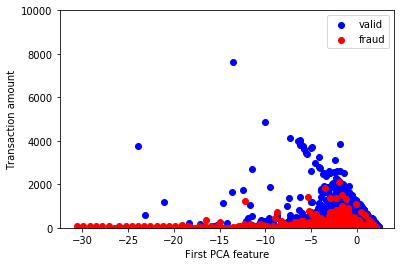

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2866    6]
 [  18   81]]
Fold 1
[[2861   11]
 [  19   80]]
Fold 2
[[2857   15]
 [  29   69]]
Fold 3
[[2861   10]
 [  30   68]]
Fold 4
[[2860   11]
 [  18   80]]
Final Confusion Matrix
[[2861.    10.6]
 [  22.8   75.6]]
False negatives (valid): 0.003691321911129684
False positives (fraud): 0.23170731707317077


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2867    5]
 [  17   82]]
Fold 1
[[2868    4]
 [  17   82]]
Fold 2
[[2870    2]
 [  22   76]]
Fold 3
[[2865    6]
 [  20   78]]
Fold 4
[[2869    2]
 [  14   84]]
Final Confusion Matrix
[[2867.8    3.8]
 [  18.    80.4]]
False negatives (valid): 0.001323304081348377
False positives (fraud): 0.18292682926829268


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2775   97]
 [   9   90]]
Fold 1
[[2783   89]
 [  10   89]]
Fold 2
[[2780   92]
 [   6   92]]
Fold 3
[[2739  132]
 [  11   87]]
Fold 4
[[2764  107]
 [   6   92]]
Final Confusion Matrix
[[2768.2  103.4]
 [   8.4   90. ]]
False negatives (valid): 0.036007800529321635
False positives (fraud): 0.08536585365853658


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2871    1]
 [  21   78]]
Fold 1
[[2870    2]
 [  20   79]]
Fold 2
[[2870    2]
 [  25   73]]
Fold 3
[[2870    1]
 [  20   78]]
Fold 4
[[2870    1]
 [  19   79]]
Final Confusion Matrix
[[2.8702e+03 1.4000e+00]
 [2.1000e+01 7.7400e+01]]
False negatives (valid): 0.0004875330826020337
False positives (fraud): 0.21341463414634146


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2861   11]
 [  48   51]]
Fold 1
[[2865    7]
 [  55   44]]
Fold 2
[[2863    9]
 [  46   52]]
Fold 3
[[2858   13]
 [  50   48]]
Fold 4
[[2859   12]
 [  46   52]]
Final Confusion Matrix
[[2861.2   10.4]
 [  49.    49.4]]
False negatives (valid): 0.003621674327900822
False positives (fraud): 0.4979674796747967


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2870    2]
 [  19   80]]
Fold 1
[[2869    3]
 [  21   78]]
Fold 2
[[2866    6]
 [  21   77]]
Fold 3
[[2866    5]
 [  25   73]]
Fold 4
[[2868    3]
 [  12   86]]
Final Confusion Matrix
[[2867.8    3.8]
 [  19.6   78.8]]
False negatives (valid): 0.001323304081348377
False positives (fraud): 0.1991869918699187


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2852   20]
 [  16   83]]
Fold 1
[[2852   20]
 [  17   82]]
Fold 2
[[2851   21]
 [  13   85]]
Fold 3
[[2847   24]
 [  18   80]]
Fold 4
[[2849   22]
 [  13   85]]
Final Confusion Matrix
[[2850.2   21.4]
 [  15.4   83. ]]
False negatives (valid): 0.00745229140548823
False positives (fraud): 0.1565040650406504


### Logistic Regression

In [16]:
def train_logistic_regression(data, folds, labels, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        print('Fold', i)
        print(conf_mat)
        print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [17]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, folds, labels, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[2871    1]
 [  17   82]]
Area under curve: 0.9870220308938972
Fold 1
[[2870    2]
 [  16   83]]
Area under curve: 0.9770546692552264
Fold 2
[[2870    2]
 [  22   76]]
Area under curve: 0.9786005627877892
Fold 3
[[2870    1]
 [  20   78]]
Area under curve: 0.9749820513367311
Fold 4
[[2870    1]
 [  14   84]]
Area under curve: 0.9795420780642455
Final Confusion Matrix
[[2.8702e+03 1.4000e+00]
 [1.7800e+01 8.0600e+01]]
F1 score: 0.893569844789357
Recall: 0.8191056910569106
Precision: 0.9829268292682927
AUC: 0.9794402784675779
Checking class weight None and coefficient 0.016681005372000592
Fold 0
[[2871    1]
 [  17   82]]
Area under curve: 0.9874616639936975
Fold 1
[[2870    2]
 [  15   84]]
Area under curve: 0.9770617033848232
Fold 2
[[2870    2]
 [  22   76]]
Area under curve: 0.9794710363253938
Fold 3
[[2870    1]
 [  20   78]]
Area under curve: 0.9751704234462855
Fold 4
[[2870    1]
 [  14   84]]
Area under curve: 0.979947255809

Fold 0
[[2820   52]
 [  10   89]]
Area under curve: 0.984306856869531
Fold 1
[[2808   64]
 [  10   89]]
Area under curve: 0.9678329253538167
Fold 2
[[2817   55]
 [   7   91]]
Area under curve: 0.984242652492752
Fold 3
[[2799   72]
 [  12   86]]
Area under curve: 0.97393356506657
Fold 4
[[2792   79]
 [   6   92]]
Area under curve: 0.9795580719226039
Final Confusion Matrix
[[2807.2   64.4]
 [   9.    89.4]]
F1 score: 0.7089611419508328
Recall: 0.9085365853658537
Precision: 0.5812743823146944
AUC: 0.9779748143410547
Checking class weight balanced and coefficient 0.1291549665014884
Fold 0
[[2820   52]
 [  10   89]]
Area under curve: 0.9840043892968684
Fold 1
[[2809   63]
 [  10   89]]
Area under curve: 0.9679067837145832
Fold 2
[[2814   58]
 [   7   91]]
Area under curve: 0.9843208174634757
Fold 3
[[2797   74]
 [  12   86]]
Area under curve: 0.9736279046623875
Fold 4
[[2789   82]
 [   6   92]]
Area under curve: 0.979570511590216
Final Confusion Matrix
[[2805.8   65.8]
 [   9.    89.4]]
F1 

In [19]:
#Notice that if we fully downsample the dataset so that valid and fraud are equally represented, we have much more consistent metrics.
#Then we see that the recommended parameters begin to converge.

csv_data2 = [row for row in csv_data if int(row[-1]) == 1 or random.random() < 0.00164/.05]

# Format: Time, V1, ..., V28, Amount, Class
data2 = np.array([[float(x) for x in row[1:-1]] for row in csv_data2])
times2 = np.array([float(row[0]) for row in csv_data2])
labels2 = np.array([int(row[-1]) for row in csv_data2])

data_sc2 = scaler.fit_transform(data2)

fraud_indices2 = np.where(labels2 == 1)[0]
np.random.shuffle(fraud_indices2)
fraud_splits2 = np.array_split(fraud_indices2, 5)

valid_indices2 = np.where(labels2 == 0)[0]
np.random.shuffle(valid_indices2)
valid_splits2 = np.array_split(valid_indices2, 5)

folds2 = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits2, valid_splits2)]

weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc2, folds2, labels2, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Fold 0
[[94  0]
 [18 81]]
Area under curve: 0.9758220502901354
Fold 1
[[94  0]
 [21 78]]
Area under curve: 0.9727057812164195
Fold 2
[[93  1]
 [24 74]]
Area under curve: 0.9636343899261832
Fold 3
[[94  0]
 [19 79]]
Area under curve: 0.98762483716891
Fold 4
[[94  0]
 [16 82]]
Area under curve: 0.9866478506296136
Final Confusion Matrix
[[93.8  0.2]
 [19.6 78.8]]
F1 score: 0.8883878241262683
Recall: 0.8008130081300813
Precision: 0.9974683544303797
AUC: 0.9772869818462524
Checking class weight None and coefficient 0.016681005372000592
Fold 0
[[94  0]
 [18 81]]
Area under curve: 0.9771115409413282
Fold 1
[[94  0]
 [20 79]]
Area under curve: 0.9728132387706856
Fold 2
[[93  1]
 [23 75]]
Area under curve: 0.9663482414242293
Fold 3
[[94  0]
 [16 82]]
Area under curve: 0.987733391228832
Fold 4
[[94  0]
 [15 83]]
Area under curve: 0.9867564046895354
Final Confusion Matrix
[[93.8  0.2]
 [18.4 80. ]]
F1 score: 0.8958566629339305
Recall: 0.813008130081

Fold 4
[[92  2]
 [ 9 89]]
Area under curve: 0.9857794181502388
Final Confusion Matrix
[[92.4  1.6]
 [11.2 87.2]]
F1 score: 0.9316239316239316
Recall: 0.8861788617886178
Precision: 0.981981981981982
AUC: 0.9812422970477682
Checking class weight balanced and coefficient 0.5994842503189409
Fold 0
[[93  1]
 [ 8 91]]
Area under curve: 0.9821620459918333
Fold 1
[[91  3]
 [10 89]]
Area under curve: 0.9745325596389426
Fold 2
[[93  1]
 [16 82]]
Area under curve: 0.9762266608771168
Fold 3
[[92  2]
 [ 9 89]]
Area under curve: 0.9862136343899263
Fold 4
[[91  3]
 [ 9 89]]
Area under curve: 0.9853452019105514
Final Confusion Matrix
[[92.   2. ]
 [10.4 88. ]]
F1 score: 0.9341825902335457
Recall: 0.8943089430894309
Precision: 0.9777777777777777
AUC: 0.980896020561674
Checking class weight balanced and coefficient 1.0
Fold 0
[[93  1]
 [ 7 92]]
Area under curve: 0.9824844186546315
Fold 1
[[91  3]
 [10 89]]
Area under curve: 0.9737803567590801
Fold 2
[[93  1]
 [14 84]]
Area under curve: 0.976118106817194

# kNN

In [20]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    return confusion_mat

In [21]:
for k in [5, 7, 9, 11]:
    conf = train_KNN(data, k)
    print('Confusion Matrix:')
    print(conf)
    print()

Fold 0
[[2869    3]
 [  26   73]]
Fold 1
[[2870    2]
 [  33   66]]
Fold 2
[[2870    2]
 [  27   71]]
Fold 3
[[2871    0]
 [  29   69]]
Fold 4
[[2870    1]
 [  25   73]]
Final Confusion Matrix
[[2.87e+03 1.60e+00]
 [2.80e+01 7.04e+01]]
False negatives (valid): 0.0005571806658308957
False positives (fraud): 0.2845528455284553
Confusion Matrix:
[[2.87e+03 1.60e+00]
 [2.80e+01 7.04e+01]]

Fold 0
[[2869    3]
 [  28   71]]
Fold 1
[[2870    2]
 [  33   66]]
Fold 2
[[2870    2]
 [  33   65]]
Fold 3
[[2871    0]
 [  32   66]]
Fold 4
[[2870    1]
 [  26   72]]
Final Confusion Matrix
[[2.87e+03 1.60e+00]
 [3.04e+01 6.80e+01]]
False negatives (valid): 0.0005571806658308957
False positives (fraud): 0.30894308943089427
Confusion Matrix:
[[2.87e+03 1.60e+00]
 [3.04e+01 6.80e+01]]

Fold 0
[[2869    3]
 [  28   71]]
Fold 1
[[2870    2]
 [  34   65]]
Fold 2
[[2870    2]
 [  37   61]]
Fold 3
[[2871    0]
 [  36   62]]
Fold 4
[[2870    1]
 [  27   71]]
Final Confusion Matrix
[[2.87e+03 1.60e+00]
 [3.24e